**A.** Préliminaires

**A.1.** Imports :

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir as ls
from os.path import join
import time
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torchvision
import torch.nn as nn   
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import copy
import pickle
import time

**A.2.** Montage du répertoire contenant les sources et le dataset :

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**A.3.** imports locaux 

In [ ]:
os.chdir('/content/drive/MyDrive/sameCamera/src_real')

In [ ]:
from archis_mtl import *
from utile_mtll import *

**A.4** Copie des répertoires et chemin

In [ ]:
dir_train = '/root/ds_sameCamera/ds_sameCamera_train'
dir_val = '/root/ds_sameCamera/ds_sameCamera_val'
dir_test = '/root/ds_sameCamera/ds_sameCamera_test'

In [ ]:
# ! tar -cf ../ds_sameCamera/ds_sameCamera_train.tar   ../ds_sameCamera/ds_sameCamera_train
# ! tar -cf ../ds_sameCamera/ds_sameCamera_val.tar   ../ds_sameCamera/ds_sameCamera_val
# ! tar -cf ../ds_sameCamera/ds_sameCamera_test.tar   ../ds_sameCamera/ds_sameCamera_test

if not os.path.isdir('/root/ds_sameCamera/ds_sameCamera_train'):
  !cp -r ../ds_sameCamera/ds_sameCamera_train.tar	/root/
  !tar -xf  /root/ds_sameCamera_train.tar  -C /root/

  !cp -r ../ds_sameCamera/ds_sameCamera_val.tar	/root/
  !tar -xf  /root/ds_sameCamera_val.tar  -C /root

  # !cp -r ../ds_sameCamera/ds_sameCamera_test.tar	/root/
  # !tar -xf  /root/ds_sameCamera_test.tar  -C /root

**B** Transformations pour l'augmentation de données 

In [ ]:
from utile_datasets_transforms import *

**C.** Visualisation des données

In [ ]:
# Instance of transforms:
size_in = 256+32
size_out = 256-32
tr = tr_ReID_train(size_in, size_out)

# Instance of Dataset_ReID
K = 4
S = 2

kwargs = {'size_in': size_in,
          'size_out': size_out,
          'angle_max':20,
          'ph':0.20,  
          'pv':0.15,
          'marginsup':0.05,
          'margininf':0.05,
          'cropped_prop':0.8,
          'zoom':33
          }

ds_train = Dataset_ReID(dir_train, tr, K, S, **kwargs)    

batch_size = 8
dl_viz = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, 
                                       shuffle=True, num_workers=2)


In [ ]:
it = iter(dl_viz)

In [ ]:
imgs, labels, codes = next(it)


In [ ]:
def imshow(inp, title=None):
    #Imshow for Tensor
    plt.figure(figsize = (20,20))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

## Make a grid from batch
imgs = imgs.reshape((batch_size * K * S, 3, size_out, size_out))
out0 = torchvision.utils.make_grid(imgs)

#
print(labels)

imshow(out0)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(codes[0]['angle'])
print(codes[1]['angle'])

print(codes[0]['perspective'][1])
print(codes[1]['perspective'][1])

print(codes[0]['cropping'])
print(codes[1]['cropping'])

print(codes[0]['flip'])
print(codes[1]['flip'])

tensor([ -6,  14,   4,   0,  -6,   1, -16,  15])
tensor([ 14,  14, -16,   0,  -6,   1,   4,  -5])
[[tensor([ -3.3099,  -3.0525, -34.0774, -13.7658, -26.6253, -19.7995,  -6.6534,
        -37.5754], dtype=torch.float64), tensor([ -1.5150,  -1.5580, -11.9094, -11.4668,  -4.8965,  -2.2528, -32.3715,
        -10.9010], dtype=torch.float64)], [tensor([299.9576, 325.5299, 309.6241, 345.3629, 311.1738, 317.2165, 313.7499,
        330.2347], dtype=torch.float64), tensor([ -1.5150,  -1.5580, -11.9094, -11.4668,  -4.8965,  -2.2528, -32.3715,
        -10.9010], dtype=torch.float64)], [tensor([341.7996, 329.8464, 320.6646, 343.7610, 320.8916, 291.4061, 291.1298,
        301.1108], dtype=torch.float64), tensor([317.2587, 301.7332, 289.8923, 294.8024, 316.7043, 316.4441, 320.1261,
        302.4547], dtype=torch.float64)], [tensor([-17.0387,  -7.9253, -52.5381, -21.0719, -28.9207, -36.6107, -33.9136,
         -0.7304], dtype=torch.float64), tensor([321.3933, 327.6642, 315.5020, 309.4962, 316.9227, 323

**D.** Entraînement

In [ ]:
from utile_trainReId import *

In [ ]:
# Instance of transforms:
size_in = 256+32
size_out = 256-32
tr = tr_ReID_train(size_in, size_out)

# Configuration
batch_size = 12
S = 2
K = 5
N = batch_size * S
Kval = 5
batch_size_val = 16
prodKS = {}
prodKS['train'] =  batch_size * S
prodKS['val'] =  batch_size_val * S

num_epochs = 100
lr = 0.001 
num_latentdims = 100 


kwargs = {'size_in': size_in,
          'size_out': size_out,
          'angle_max':20,
          'ph':0.20,  
          'pv':0.15,
          'marginsup':0.05,
          'margininf':0.05,
          'cropped_prop':0.8,
          'zoom':33
          }
PATH_final_checkpoint = r"../models/resnet50_eraser_final_checkpoint" #r"../models/resnet50_200ep_checkpoint"-> lastepoq ou r"../models/resnet50_100ep_checkpoint" -> best epoch
PATH_bestacc_checkpoint = r"../models/resnet50_erazer_checkpoint" #r"../models/resnet50_lastcheckpoint"

In [ ]:
manualSeed = 0
torch.manual_seed(manualSeed)

#def loaders
ds_train = Dataset_ReID(dir_train, tr, K, S, **kwargs)    
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, 
                                       shuffle=True, num_workers=2)

ds_val = Dataset_ReID(dir_val, tr, Kval, S, **kwargs)    
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=batch_size_val, 
                                       shuffle=False, num_workers=2)

dl = {'train': dl_train, 'val':dl_val}

In [ ]:
# chargement/adaptation de la dernière couche du modèle:
model = torchvision.models.resnet50(progress=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_latentdims)

model = model.cuda()

# Fonction de coût
margin = None
normalize_feature = False
tripletloss = TripletLoss(margin=margin)
tripletloss = WeightedRegularizedTriplet()

# Optim
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.2)


In [ ]:
# init stats, best weights from scratch
"""
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_losses=[]
val_losses=[]
train_accs = []
val_accs = []
max_acc = 0
last_epoch = 0
best_AP = 0.0
"""

In [ ]:
# init stats, best weights from checkpoint

checkpoint = torch.load(PATH_bestacc_checkpoint)
train_losses = checkpoint['train_losses']

val_losses = checkpoint['val_losses']

train_accs = checkpoint['train_accs']
val_accs = checkpoint['val_accs']
max_acc = val_accs[-1]
last_epoch = checkpoint['epoch']
model_weights = checkpoint['model_state_dict']
optimizer_state_dict = checkpoint['optimizer_state_dict']

model.load_state_dict(model_weights)
optimizer.load_state_dict(optimizer_state_dict)


In [ ]:
"""
# Pour le dev de 
thresholds = torch.arange(0,20,0.01)
M = epoch_distToCenters.permute(0,2,1,3)
nB, K, bN, _ = M.shape
Q = torch.zeros(bN,bN, dtype=torch.bool)
Q[range(bN), range(bN)] = True

TPRs = []
FPRs = []
Recalls = []
Precisions = []
eps = 1e-5
D = M[:,:,Q]
antiD = M[:,:,Q.logical_not()]

for t in thresholds:

    Recall = ((D < t).sum()/D.numel()).cpu().item()
  #  FNR = (D >= t).sum()/D.numel()
  #  TNR = (antiD > t).sum()/antiD.numel()
    FPR = ((antiD <= t).sum()/antiD.numel()).cpu().item()
    Precision = ((D < t).sum()/((D < t).sum() + (antiD <= t).sum() + eps)).cpu().item()
  #  print(t.item())
  #  print('{:.3f}'.format(TPR))
  #  print('{:.3f}'.format(FPR))
  #  print('----')
  #  TPRs.append(TPR)
  #  FPRs.append(FPR)
    Recalls.append(Recall)
    Precisions.append(Precision)

  

plt.plot(Recalls, Precisions)
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
print(auc(np.array(Recalls), np.array(Precisions)))
print(average_precision_score)
y_true = 0*M 
y_true[:,:,Q] = 1
y_true = y_true.flatten().cpu().numpy()
y_score = -M.flatten().cpu().numpy()
# Compute AP better than approx by trapezes 
# (see eg https://towardsdatascience.com/the-wrong-and-right-way-to-approximate-area-under-precision-recall-curve-auprc-8fd9ca409064)
print(average_precision_score(y_true,y_score))
"""
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

def get_AP(epoch_distToCenters):
  M = epoch_distToCenters.permute(0,2,1,3)
  nB, K, bN, _ = M.shape
  Q = torch.zeros(bN,bN, dtype=torch.bool)
  Q[range(bN), range(bN)] = True
  y_true = 0*M 
  y_true[:,:,Q] = 1
  y_true = y_true.flatten().cpu().numpy()
  y_score = -M.flatten().cpu().numpy()
  return average_precision_score(y_true,y_score)

In [ ]:
def czech_distToCenters(feat):
  with torch.no_grad():
    bs, K, nld = feat.shape
    # czech-moyennes: de tailles bs, K, nld
    # on applatit les dim. 1,2 et on enlève le premier élément diag.
    # on met les termes diagonaux en fin de ligne et on les éjecte
    # on remet en forme

    means = feat.unsqueeze(dim=1)\
                .expand(bs,K,K,nld)\
                .reshape(bs,K*K,nld)[:,1:,:]\
                .view(bs,K-1,K+1,nld)[:,:,:-1,:]\
                .reshape(bs,K, K-1,nld)\
                .mean(dim=2)
    # means = feat.mean(dim=1)
    # distances aux moyennes:
    # on calcule distance(feat[i,k,:], means[l,k,:])
    dists = []
    for k in range(K):
      # distances élm. k x mean sans elmt k:
      dists.append(euclidean_dist(feat[:,k,:], means[:,k,:]).unsqueeze(1)) #[:,k,:]))
    
    return torch.cat(dists, dim=1)

"""
# pour le dév de czech_distToCenters:
import torch

a = torch.rand(5,4,3)
b = a.unsqueeze(dim=1).expand(5,4,4,3)

print(b.shape)
# option 1:
M = (torch.zeros(4,4) == 0)
M[range(4), range(4)] = False  
print(M)
print(b[:,M,:].shape)
print(a[:,1:,:].mean(dim = 1))
print(b[:,M,:].view(5,4,3,3).mean(dim = 2)[:,0,:])
# option 2, plus simple (pas de matrice supplémentaire)
print(a.unsqueeze(dim=1).expand(5,4,4,3).reshape(5,16,3)[:,1:,:].view(5,4-1,4+1,3)[:,:,:-1,:].reshape(5,4, 4-1,3).mean(dim=2)[:,0,:])
print(czech__distToCenters(a).shape)
"""

'\n# pour le dév de czech_distToCenters:\nimport torch\n\na = torch.rand(5,4,3)\nb = a.unsqueeze(dim=1).expand(5,4,4,3)\n\nprint(b.shape)\n# option 1:\nM = (torch.zeros(4,4) == 0)\nM[range(4), range(4)] = False  \nprint(M)\nprint(b[:,M,:].shape)\nprint(a[:,1:,:].mean(dim = 1))\nprint(b[:,M,:].view(5,4,3,3).mean(dim = 2)[:,0,:])\n# option 2, plus simple (pas de matrice supplémentaire)\nprint(a.unsqueeze(dim=1).expand(5,4,4,3).reshape(5,16,3)[:,1:,:].view(5,4-1,4+1,3)[:,:,:-1,:].reshape(5,4, 4-1,3).mean(dim=2)[:,0,:])\nprint(czech__distToCenters(a).shape)\n'

In [ ]:
# Training loop
since = time.time()

for epoch in range(last_epoch, last_epoch + num_epochs):
    print('Epoch {}/{}'.format(epoch, last_epoch + num_epochs - 1))
    print('-' * 10)


    # Each epoch has a training and validation phase
    if epoch % 4 == 0:
      phases = ['train','val']
    else:
      phases = ['train']

    for phase in phases: 
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_dap = 0.0
        running_dan = 0.0
        running_prev = []
        running_obs = []
        running_distToCenters = []
        # Iterate over data.
        
        t = time.time()

        for i, (images, labels, _)  in enumerate(dl[phase]):
            # print(i)
            if phase == 'train':
                optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                bs, SK, ch, s, s= images.shape     
                bN = bs * SK // K                    
                images = images.view(bN*K,ch,s,s).cuda()
                labels = labels.detach().reshape(bN*K).cuda()

                global_feat = model(images)
                loss, dist_ap, dist_an = tripletloss(global_feat, labels, normalize_feature=normalize_feature)
                
                mean_dap = torch.mean(dist_ap.detach())
                mean_dan = torch.mean(dist_an.detach())
                # # print('dap')
                # print(mean_dap)
                # # print('dan')
                # print(mean_dan)
                # # print('loss')
                # print(loss)
            if phase == 'train':
                loss.backward()
                optimizer.step()
           
          
            running_loss += loss.item() * bN
            running_dap += mean_dap.item() * bN
            running_dan += mean_dan.item() * bN   

            # simple means : 
            """
            centers = global_feat.view(bN, K, num_latentdims).mean(dim=1)
            distToCenters = euclidean_dist(global_feat, centers)
            """
            # czech means : 
            distToCenters = czech_distToCenters(
                                global_feat.view(bN, K, num_latentdims))

            prev = torch.min(distToCenters.view(K*bN,bN), dim=1)[1].tolist()
            obs = torch.arange(bN).repeat_interleave(K).tolist()
            running_prev += prev
            running_obs += obs

            # pour un caclul de l'AUC:
            if phase == 'val':
              running_distToCenters.append(distToCenters) 

            del images, labels, dist_ap, dist_an
            del global_feat
            del loss
            torch.cuda.empty_cache()
        
        L = len(dl[phase]) * prodKS[phase] 
        epoch_loss = running_loss / (L)
        epoch_dap = running_dap / (L)
        epoch_dan = running_dan / (L)
        epoch_acc = (torch.tensor(running_prev) == torch.tensor(running_obs).long()).sum().float() / len(running_prev)

        epoch_duration = (time.time() - t)

        if phase == 'train':
            print('{} Loss: {:.4f} DAP: {:.4f} DAN: {:.4f} ACC: {:.4f} Duration: {:.2f}'.format(
                phase, epoch_loss, epoch_dap, epoch_dan, epoch_acc, epoch_duration))
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc)

        elif phase == 'val':
            epoch_distToCenters = torch.stack(running_distToCenters[:-1])
            AP = get_AP(epoch_distToCenters)
            print('{} Loss: {:.4f} DAP: {:.4f} DAN: {:.4f} ACC: {:.4f} AP: {:.4f} Duration: {:.2f}'.format(
                phase, epoch_loss, epoch_dap, epoch_dan, epoch_acc, AP, epoch_duration))
            
            val_losses.append(epoch_loss)                     
            val_accs.append(epoch_acc)
        # deep copy the model
        if phase == 'val' and epoch_acc >= max_acc:
            print('best acc')
            max_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

            torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'train_accs': train_accs,
              'val_accs':val_accs,
              'train_losses':train_losses,
              'val_losses':val_losses,
              'best_acc':epoch_acc
              }, PATH_bestacc_checkpoint)

    scheduler.step()  

Epoch 324/423
----------


KeyboardInterrupt: ignored

In [ ]:
# epoch_distToCenters[:,range(32),:,range(32)][:,:,0].shape # == epoch_distToCenters[0,range(32),0,range(32)]
thresholds = torch.arange(0,5,0.1)
M = epoch_distToCenters.permute(0,2,1,3)
nB, K, bN, _ = M.shape
Q = torch.zeros(bN,bN, dtype=torch.bool)
Q[range(bN), range(bN)] = True
print(M[:,:,range(32),range(32)].shape) 
print(M[:,:,Q] == M[:,:,range(32),range(32)])
print(M[:,:,Q.logical_not()].shape)
print(32*32 - 32)


In [ ]:
1e-6/10

In [ ]:
bN = 5
torch.ones(bN,bN, dtype=torch.bool).logical_not()

In [ ]:
# Mesure de la capacité à "exclure" et pas à réidentifier

# Idée : on se donne un seuil t "universel" qu'on fait varier.
# on stocke les valeurs de dist(czech_center_k - x_k)  et dist(czech_center_k - x'_k)
# A la fin de la période, on calcule l'AUC
#taille de epoch_distToCenters : nB, bN, K, bN





# epoch_distToCenters : (nb, bN, K, bN)

  with torch.no_grad():
    bs, K, nld = feat.shape
    # czech-moyennes: de tailles bs, K, nld
    # on applatit les dim. 1,2 et on enlève le premier élément diag.
    # on met les termes diagonaux en fin de ligne et on les éjecte
    # on remet en forme

    means = feat.unsqueeze(dim=1)\
                .expand(bs,K,K,nld)\
                .reshape(bs,K*K,nld)[:,1:,:]\
                .view(bs,K-1,K+1,nld)[:,:,:-1,:]\
                .reshape(bs,K, K-1,nld)\
                .mean(dim=2)
    # means = feat.mean(dim=1)
    # distances aux moyennes:
    # on calcule distance(feat[i,k,:], means[l,k,:])
    dists = []
    for k in range(K):
      # distances élm. k x mean sans elmt k:
      dists.append(euclidean_dist(feat[:,k,:], means[:,k,:]).unsqueeze(1)) #[:,k,:]))
    
    return torch.cat(dists, dim=1).view(K*bs,bs)




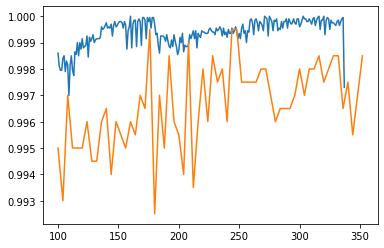

In [ ]:
ltl = len(train_losses)
lvl = len(val_losses)

lta = len(train_accs)
lva = len(val_accs)
start = 100
plt.plot(np.arange(lta)[start:],train_accs[start:])
plt.plot(4*np.arange(lva)[start//4:], val_accs[start//4:])

In [ ]:

torch.save({
  'epoch': epoch,
  'model_state_dict': model.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'train_accs': train_accs,
  'val_accs':val_accs,
  'train_losses':train_losses,
  'val_losses':val_losses,
  'best_acc':epoch_acc
  }, PATH_bestacc_checkpoint)